# Code gists for spiking TRAMESINO

## TRAMESINO: Traffic Memory System for Intelligent Optimization of Road Traffic Control

In [22]:
%matplotlib inline
# import Nengo NEF for spiking computation and semantic pointer architecture (VSA)
import numpy as np
import nengo
import nengo_spa as spa

### System design

Define the convolutive power by:
$$
\begin{equation}
  \mathbf{v}^{p} := \Re\left(IDFT \left(\left(DFT_{j}\left(\mathbf{v}\right)^{p}\right)_{j=0}^{D-1}\right)\right),
  \label{eq:conv_power}
\end{equation}
$$
Circular convolution can be written as a combination of the Discrete Fourier Transform, Inverse Discrete Fourier Transform and element-wiese multiplication $\odot$:
$$
\begin{equation}
  \mathbf{v} \otimes \mathbf{w} = IDFT \left(DFT(\mathbf{v}) \odot DFT(\mathbf{w})\right).
  \label{eq:conv_dft}
\end{equation}
$$

In [23]:
def power(vector, exponent, scale=1):
    x = np.fft.ifft(np.fft.fft(vector.v) ** (exponent*scale)).real
    return spa.SemanticPointer(data=x)

We create a vocabulary and use the unitary vector $BASE$ for encoding traffic data in high-dimensional vectors $C_0, \ldots, C_4$ to represent each traffic data type (green time, flow of cars) or type and $T_0, T_1$ for encoding the temporal structure.
We use unitary vectors $\mathbf{u}$, since they have some desirable properties, namely 
 - $\left|\mathbf{u} \right| = 1$
 - $\mathbf{u}^{p}$ is still unitary for any $p \in \mathbb{R}$
 - convolution with unitary vectors preserves the norm, i.e., $\left|\mathbf{v}\right| = \left| \mathbf{v} \otimes \mathbf{u} \right|$ for any other vector $\mathbf{v}$

In [24]:
def create_random_vocab(dim,
                        num_vector_items,
                        num_time_vectors,
                        seed,
                        b_unitary=False,
                        spatial_ids=['X', 'Y']):
   
    # create spa vocabulary object
    vocab = spa.Vocabulary(dimensions=dim,
                           pointer_gen=np.random.RandomState(seed=seed))
    
    # create base vectors for exponentiation/convolutive power to encode scalar values
    for k in spatial_ids:
        vocab.populate(k+'.unitary()')
        
    # create vocabulary vectors for traffic data classes corresponding to different traffic data quantities
    for i in np.arange(num_vector_items):
        k = 'C%s'%str(i).zfill(len(str(num_vector_items)))

        if b_unitary:
            vocab.populate(k+'.unitary()')
        else:
            vocab.populate(k)
    
    # create vectors for encoding time steps
    for i in np.arange(num_time_vectors):
        k = 'T%s'%str(i).zfill(len(str(num_time_vectors)))

        if b_unitary:
            vocab.populate(k+'.unitary()')
        else:
            vocab.populate(k)

    return vocab

In [25]:
num_vector_items = 5
vocab = create_random_vocab(dim=2048, num_vector_items=num_vector_items, num_time_vectors=2, seed=0, spatial_ids=['BASE'])

In [26]:
traffic_data_values = np.round(np.random.uniform(-0.99, 1, 5)*10, 3)
print(traffic_data_values)

[3.186 4.101 7.268 2.698 6.215]


We create the actual vector representation of the different traffic data values $v_i$, i.e.
$$
result = \sum_{j=1}^{M} C_j \otimes BASE^{v_j \cdot s} , 
$$
where $s$ is a scaling factor

In [27]:
def create_spa_representation(vocab, values, scale=1.):
    class_ind = 0
    num = len(values)
    result = spa.SemanticPointer(np.zeros(vocab.dimensions))

    for i, sv in enumerate(values):
        result += vocab['C%s'%str(class_ind).zfill(len(str(num)))] * power(vocab['BASE'], sv, scale=scale)
        class_ind += 1
        
    return result

In [29]:
scale=10
v = create_spa_representation(vocab, values=traffic_data_values, scale=scale)

Calculate the similarities between our vector representation and reference vector encoding other discrete values, where we expect high similarities with the actually encoded values.

In [30]:
M = 100
xx = np.linspace(-scale, scale, M)
traffic_data = 0
sims = np.zeros((M, len(traffic_data_values)))

for i, x in enumerate(xx):
    for traffic_data in range(len(traffic_data_values)):
        test_v = power(vocab['BASE'], x, scale)
        sims[i, traffic_data] = test_v.compare(vocab['C%i'%traffic_data].__invert__()*v)

### Analysis

In [31]:
def plot(values, scale, similarities):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    ax.grid(ls=":")
    for i in range(len(values)):
        plt.plot(xx*scale, similarities[:,i], label='traffic data C%i'%i)
    plt.ylabel('Similarity', fontsize=16)
    plt.xlabel('reference values', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    for i, traffic_data in enumerate(values):
        if i == (len(values)-1):
            plt.axvline(
                traffic_data*scale,
                ls='--',
                alpha=1.,
                label='True values'
            )
        else:
            plt.axvline(
                    traffic_data*scale,
                    ls='--',
                    alpha=1.,
                )
    plt.legend(loc=1, fontsize=16)

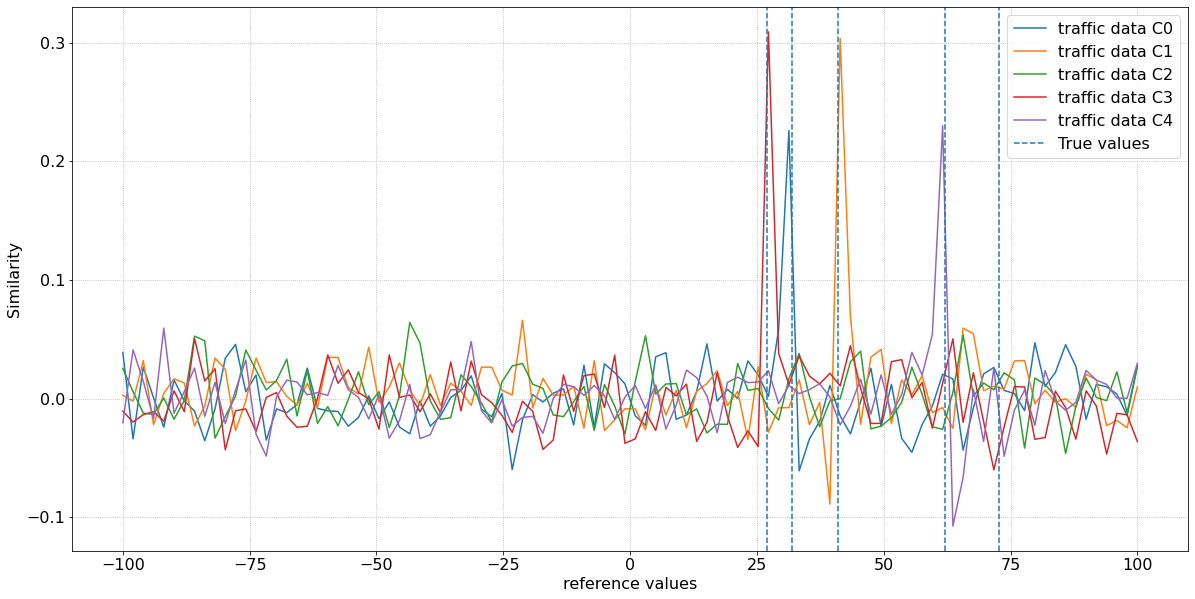

In [32]:
plot(values=traffic_data_values, scale=scale, similarities=sims)

Now, we generate some traffic data samples to create another vector representation at, for instance, another time step in the time series

In [33]:
traffic_data_values_t2 = np.round(np.random.uniform(-0.99, 1, 5)*10, 3)
print(traffic_data_values_t2)

[-4.852  2.51  -5.811  7.725 -2.128]


In [34]:
w = create_spa_representation(vocab, values=traffic_data_values_t2, scale=scale)

We calculate the similarities between our vector representation and reference vector encoding other discrete values, where we expect high similarities with the actually encoded values.

In [37]:
M = 100
xx = np.linspace(-scale, scale, M)
traffic_data = 0
sims_t2 = np.zeros((M, len(traffic_data_values_t2)))

for i, x in enumerate(xx):
    for traffic_data in range(len(traffic_data_values_t2)):
        test_v = power(vocab['BASE'], x, scale)
        sims_t2[i, traffic_data] = test_v.compare(vocab['C%i'%traffic_data].__invert__()*w)

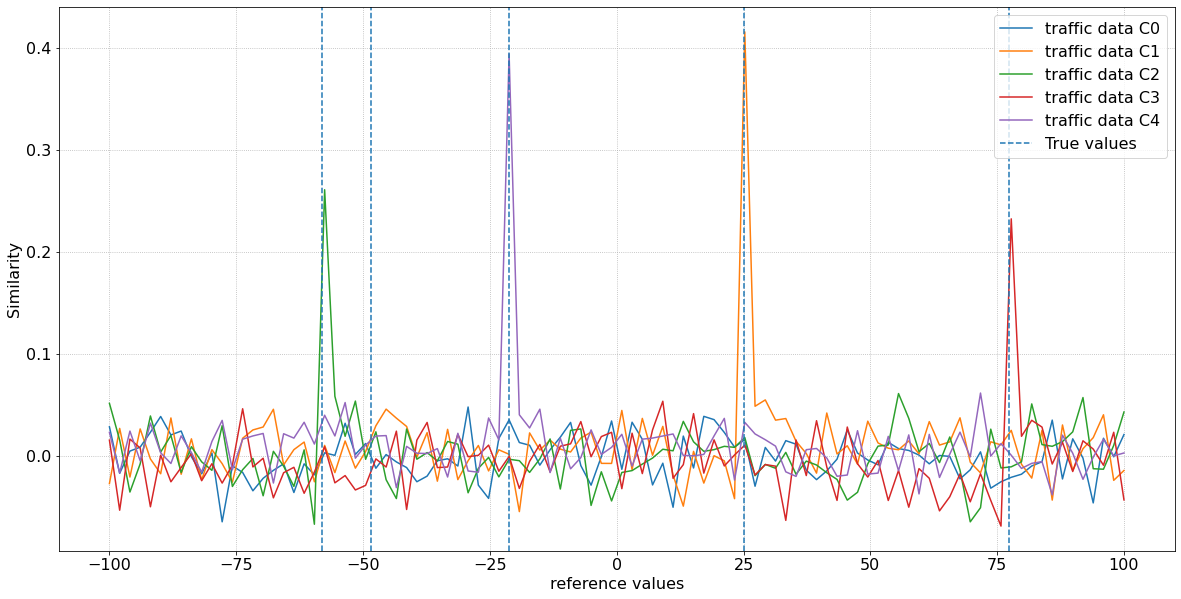

In [38]:
plot(values=traffic_data_values_t2, scale=scale, similarities=sims_t2)

If we want to encode the temporal structure, we simply bind each traffic data vector to a random vector encoding the time stamp, i.e.,
$$
timeseries = \sum_{i=1}^{N} \left( \sum_{j=1}^{M} C_j \otimes BASE^{v_j \cdot s} \right) T_{i}
$$

In [39]:
T = vocab['T0']*v + vocab['T1']*w

In [41]:
M = 100
xx = np.linspace(-scale, scale, M)
traffic_data = 0
sims_t0 = np.zeros((M, len(traffic_data_values)))

v_tilde = T * vocab['T0'].__invert__()
for i, x in enumerate(xx):
    for traffic_data in range(len(traffic_data_values)):
        
        test_v = power(vocab['BASE'], x, scale)
        sims_t0[i, traffic_data] = test_v.compare(vocab['C%i'%traffic_data].__invert__()*v_tilde)
        
sims_t1 = np.zeros((M, len(traffic_data_values_t2)))

w_tilde = T * vocab['T1'].__invert__()
for i, x in enumerate(xx):
    for traffic_data in range(len(traffic_data_values_t2)):
        test_v = power(vocab['BASE'], x, scale)
        sims_t1[i, traffic_data] = test_v.compare(vocab['C%i'%traffic_data].__invert__()*w_tilde)

With the following plots, we show that we can decode the originally encoded values back out from the time series vector as well.

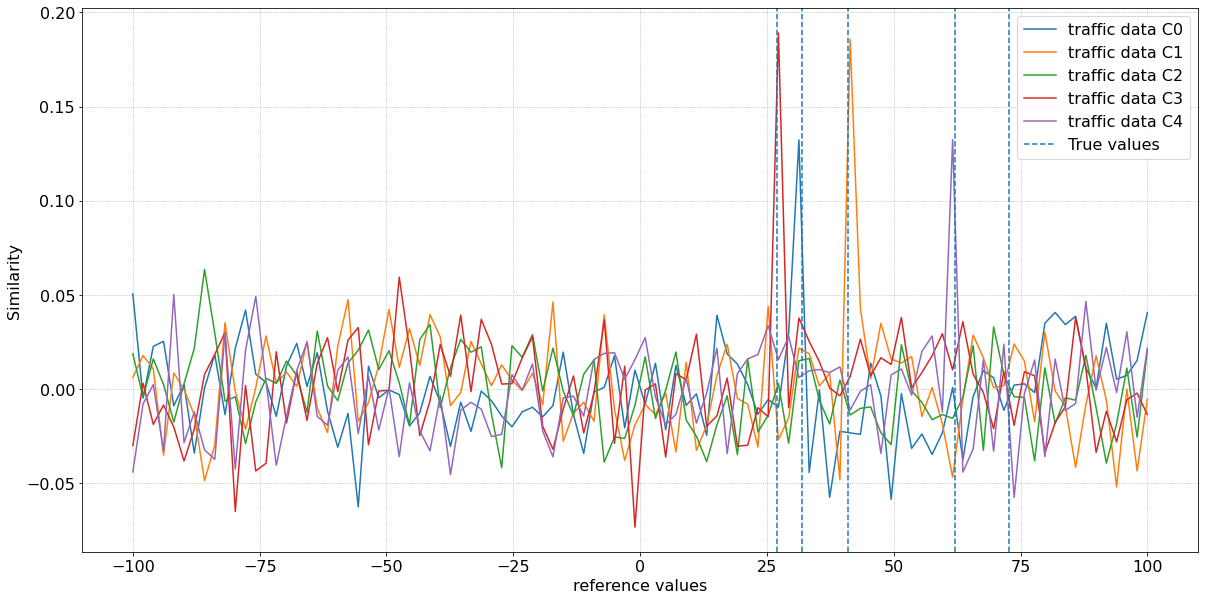

In [42]:
plot(values=traffic_data_values, scale=scale, similarities=sims_t0)

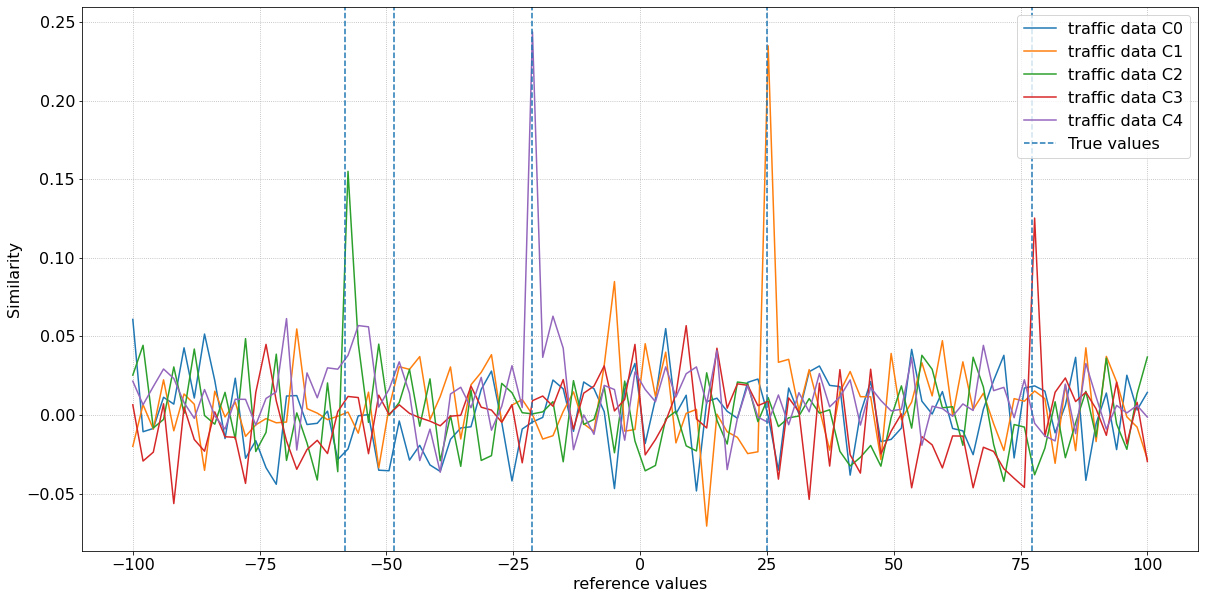

In [43]:
plot(values=traffic_data_values_t2, scale=scale, similarities=sims_t1)